In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from utils import *

In [4]:
random.seed(2024)

In [5]:
data_dir=f'../raw_data/twitter16'
filename=f'../raw_data/twitter16/twitter16_single_aff.csv'
fig_dir=f'../raw_data/fig'

# sentiment & emotion distribution

## sentiment/emotion distribution of source tweets
- select only source tweets
- plot n_comments distribution across all source tweets
- filter out source tweets with more than n_comments
- plot histogram of emotion & valence (concatenate them all and flatten them), so we get two lists for rumour & non-rumour separately

In [6]:
# filter source tweet with more than N comments
n_comments=0

df=preprocess(pd.read_csv(filename,encoding='utf-8'))
df=df[~df['structure'].str.endswith('reaction')]
df['structure']=df['structure'].apply(lambda x: collect_keys(x))
df['n_comments']=df['structure'].apply(lambda x: len(x))
# filter tweets with at least n_comments
df=df[df['n_comments']>=n_comments]

In [7]:
# source tweet sentiment distribution
rumour=df[df['rumour_type']=='rumours']
non_rumour=df[df['rumour_type']=='non-rumours']
true=rumour[rumour['factuality']=='true']
false=rumour[rumour['factuality']=='false']
unverified=rumour[rumour['factuality']=='unverified']

# sample true, false and unverified
sample_m=min(len(true),len(false),len(unverified))
true=true.sample(sample_m,random_state=2024)
false=false.sample(sample_m,random_state=2024)
unverified=unverified.sample(sample_m,random_state=2024)
print(f"true rumour size:{len(true)}")
print(f"false rumour size:{len(false)}")
print(f"unverified rumour size:{len(unverified)}")
print()

# sample rumour vs non-rumour
sample_n=min(len(rumour),len(non_rumour))
rumour=rumour.sample(sample_n,random_state=2024)
non_rumour=non_rumour.sample(sample_n,random_state=2024)
print(f"rumour size:{len(rumour)}")
print(f"non rumour size:{len(non_rumour)}")

true rumour size:201
false rumour size:201
unverified rumour size:201

rumour size:205
non rumour size:205


In [8]:
print(f"average sentiment for rumour:{rumour['emollm_sentiment'].mean()}")
print(f"average sentiment for non rumour:{non_rumour['emollm_sentiment'].mean()}")
print(f"average sentiment for true rumour:{true['emollm_sentiment'].mean()}")
print(f"average sentiment for false rumour:{false['emollm_sentiment'].mean()}")
print(f"average sentiment for unverified rumour:{unverified['emollm_sentiment'].mean()}")

average sentiment for rumour:-0.18048780487804877
average sentiment for non rumour:0.07317073170731707
average sentiment for true rumour:0.11442786069651742
average sentiment for false rumour:-0.22885572139303484
average sentiment for unverified rumour:-0.29850746268656714


In [9]:
# conduct p-test for average sentiment
pairs=[
    (rumour['emollm_sentiment'],non_rumour['emollm_sentiment']),
    (false['emollm_sentiment'],true['emollm_sentiment']),
    (unverified['emollm_sentiment'], true['emollm_sentiment']),
    (unverified['emollm_sentiment'], false['emollm_sentiment']),
]

print(f"rumour and non-rumour sentiment t-test:")
for a, b in pairs:
    # t_stat, p_value = stats.ttest_ind(a,b)
    t_stat, p_value = stats.ttest_ind(a, b, alternative='less')
    print(f"T-statistic: {t_stat}, P-value: {p_value}")

f_stat, p_value = stats.f_oneway(true['emollm_sentiment'], false['emollm_sentiment'], unverified['emollm_sentiment'])
print(f"\ntrue, false, unverified rumour sentiment ANOVA:")
print(f"F-statistic: {f_stat}, P-value: {p_value}")

rumour and non-rumour sentiment t-test:
T-statistic: -3.3750415866782606, P-value: 0.0004043701571074973
T-statistic: -4.114438224818249, P-value: 2.3573153251477636e-05
T-statistic: -4.760611382197576, P-value: 1.3510650731529893e-06
T-statistic: -0.891177589398808, P-value: 0.18668481843549362

true, false, unverified rumour sentiment ANOVA:
F-statistic: 14.23798076923077, P-value: 9.094394476520958e-07


In [10]:
rumour_emotion = sorted(sum(rumour['emollm_emotion'].apply(process_emotion), []))
non_rumour_emotion = sorted(sum(non_rumour['emollm_emotion'].apply(process_emotion), []))
true_emotion = sorted(sum(true['emollm_emotion'].apply(process_emotion), []))
false_emotion = sorted(sum(false['emollm_emotion'].apply(process_emotion), []))
unverified_emotion = sorted(sum(unverified['emollm_emotion'].apply(process_emotion), []))

In [11]:
# all_df = sorted(sum(df['emollm_emotion'].apply(process_emotion), []))
# sns_plot2(all_df,size=(16,4),xlabels=EMO,title='all tweets emotion distribution',auto=True)

## sentiment/emotion distribution of source tweets + comments
we have two ways to deal with this:
1. flatten all tweets and comments
2. compute sentiment and emotion per tweet and then aggregate

In [7]:
# filter source tweet with more than N comments
n_comments=2

df=preprocess(pd.read_csv(filename,encoding='utf-8'))
df['id']=df['id'].astype(str)
src_tweets=df[~df['structure'].str.endswith('reaction')]
src_tweets['n_comments']=src_tweets['structure'].apply(lambda x: collect_keys(x)).apply(lambda x: len(x))
src_tweets=src_tweets[src_tweets['n_comments']>=n_comments]

# sample same amount of cases for rumours and non-rumours
rumour=src_tweets[src_tweets['rumour_type']=='rumours']
non_rumour=src_tweets[src_tweets['rumour_type']=='non-rumours']

# sampling to balance data
sample_n=min(len(rumour),len(non_rumour))
rumour=rumour.sample(sample_n,random_state=2024)
non_rumour=non_rumour.sample(sample_n,random_state=2024)
print(f"rumour size:{len(rumour)}")
print(f"non rumour size:{len(non_rumour)}")

src_tweets=pd.concat([rumour,non_rumour])

rumour size:205
non rumour size:205


In [8]:
df_comments=[]
for i,(index, row) in enumerate(src_tweets.iterrows()):
    # get all comments in the source tweet thread
    structure=row['structure']
    structure_keys = collect_keys(structure)
    df_thread = df[df['id'].isin(structure_keys)]
    df_thread['emollm_emotion']=df_thread['emollm_emotion'].apply(process_emotion)
    
    # aggregate each thread, 
    # get top3 emotion, average sentiment
    all_words = list(itertools.chain.from_iterable(df_thread['emollm_emotion']))
    top_3 = [word for word, count in Counter(all_words).most_common(MOST_COMMON)]
    ave_sentiment=df_thread['emollm_sentiment'].mean()
    
    # compute entropy of emotion and sentiment valence
    # sentiment_entropy=compute_entropy(df_thread['emollm_sentiment'])
    # emotion_entropy=compute_entropy(df_thread['emollm_emotion'])
    
    df_agg=pd.DataFrame({'id':df_thread.iloc[0]['id'],
                            'emollm_emotion':[top_3],
                            # 'sentiment_entropy':sentiment_entropy,
                            # 'emotion_entropy':emotion_entropy,
                            'rumour_type':df_thread.iloc[0]['rumour_type'],
                            'factuality':df_thread.iloc[0]['factuality'],
                            'emollm_sentiment':ave_sentiment})
    df_comments.append(df_agg)
df_comments=pd.concat(df_comments)

In [9]:
df_comments

,id,emollm_emotion,rumour_type,factuality,emollm_sentiment
0,544271362022338560,"[fear, joy, optimism, love, anticipation]",rumours,true,-0.250000
0,651825062174195712,"[disgust, anger, neutral, optimism, joy]",rumours,false,-0.338462
0,745236050407194624,"[neutral, joy, optimism, disgust, fear]",rumours,unverified,-0.333333
0,663817239896821760,"[joy, neutral, optimism, disgust, sadness]",rumours,false,0.157895
0,672632899921833984,"[disgust, neutral, anger, sadness, optimism]",rumours,false,-0.324324
...,...,...,...,...,...
0,689860942671130624,"[neutral, disgust, optimism, joy, anger]",non-rumours,non-rumor,-0.012658
0,688446106943008768,"[disgust, anger, sadness, joy, anticipation]",non-rumours,non-rumor,-0.541667
0,693315824132685824,"[neutral, joy, love, optimism, disgust]",non-rumours,non-rumor,0.200000
0,692890520960397312,"[joy, neutral, sadness, optimism]",non-rumours,non-rumor,0.166667


In [10]:
# tweet comments (is_rumour)
rumour_comments=df_comments[df_comments['rumour_type'].str.startswith('rumours')]
non_rumour_comments=df_comments[df_comments['rumour_type'].str.startswith('non-rumours')]
print(f"rumour size:{len(rumour_comments)}")
print(f"non rumour size:{len(non_rumour_comments)}")
print()

# tweet comments (factuality)
true_rumour_comments=rumour_comments[rumour_comments['factuality']=='true']
false_rumour_comments=rumour_comments[rumour_comments['factuality']=='false']
unverified_rumour_comments=rumour_comments[rumour_comments['factuality']=='unverified']

sample_p=min(len(true_rumour_comments),len(false_rumour_comments),len(unverified_rumour_comments))
true_rumour_comments=true_rumour_comments.sample(sample_p,random_state=2024)
false_rumour_comments=false_rumour_comments.sample(sample_p,random_state=2024)
unverified_rumour_comments=unverified_rumour_comments.sample(sample_p,random_state=2024)

print(f"true rumour size:{len(true_rumour_comments)}")
print(f"false rumour size:{len(false_rumour_comments)}")
print(f"unverified rumour size:{len(unverified_rumour_comments)}")

rumour size:205
non rumour size:205

true rumour size:66
false rumour size:66
unverified rumour size:66


In [11]:
print(f"average sentiment for rumour comments:{rumour_comments['emollm_sentiment'].mean()}")
print(f"average sentiment for non rumour comments:{non_rumour_comments['emollm_sentiment'].mean()}")
print(f"average sentiment for true rumour comments:{true_rumour_comments['emollm_sentiment'].mean()}")
print(f"average sentiment for false rumour comments:{false_rumour_comments['emollm_sentiment'].mean()}")
print(f"average sentiment for unverified rumour comments:{unverified_rumour_comments['emollm_sentiment'].mean()}")

average sentiment for rumour comments:-0.2626035023497196
average sentiment for non rumour comments:-0.11530468826933993
average sentiment for true rumour comments:-0.2647077665130407
average sentiment for false rumour comments:-0.27390127863474195
average sentiment for unverified rumour comments:-0.25297556697676626


In [12]:
# conduct p-test for average sentiment
pairs=[
    (rumour_comments['emollm_sentiment'],non_rumour_comments['emollm_sentiment']),
    (true_rumour_comments['emollm_sentiment'],false_rumour_comments['emollm_sentiment']),
    (unverified_rumour_comments['emollm_sentiment'],true_rumour_comments['emollm_sentiment']),
    (unverified_rumour_comments['emollm_sentiment'],false_rumour_comments['emollm_sentiment']),
]

print(f"rumour and non-rumour sentiment t-test:")
for a, b in pairs:
    # t_stat, p_value = stats.ttest_ind(a,b)
    t_stat, p_value = stats.ttest_ind(a, b, alternative='less')
    print(f"T-statistic: {t_stat}, P-value: {p_value}")

f_stat, p_value = stats.f_oneway(true_rumour_comments['emollm_sentiment'], false_rumour_comments['emollm_sentiment'], unverified_rumour_comments['emollm_sentiment'])
print(f"\ntrue, false, unverified rumour sentiment ANOVA:")
print(f"F-statistic: {f_stat}, P-value: {p_value}")

rumour and non-rumour sentiment t-test:
T-statistic: -3.9157073854756614, P-value: 5.281532793695905e-05
T-statistic: 0.13225837525138767, P-value: 0.5525077915677248
T-statistic: 0.1575998202315834, P-value: 0.5624916643844643
T-statistic: 0.34469772952305244, P-value: 0.6345606774948593

true, false, unverified rumour sentiment ANOVA:
F-statistic: 0.046948506516968566, P-value: 0.9541473097217804


In [13]:
# tweet comments emotion distribution
rumour_comments_emotion = sorted(sum(rumour_comments['emollm_emotion'], []))
non_rumour_comments_emotion = sorted(sum(non_rumour_comments['emollm_emotion'], []))

# tweet comments emotion distribution
true_rumour_comments_emotion = sorted(sum(true_rumour_comments['emollm_emotion'], []))
false_rumour_comments_emotion = sorted(sum(false_rumour_comments['emollm_emotion'], []))
unverified_rumour_comments_emotion = sorted(sum(unverified_rumour_comments['emollm_emotion'], []))

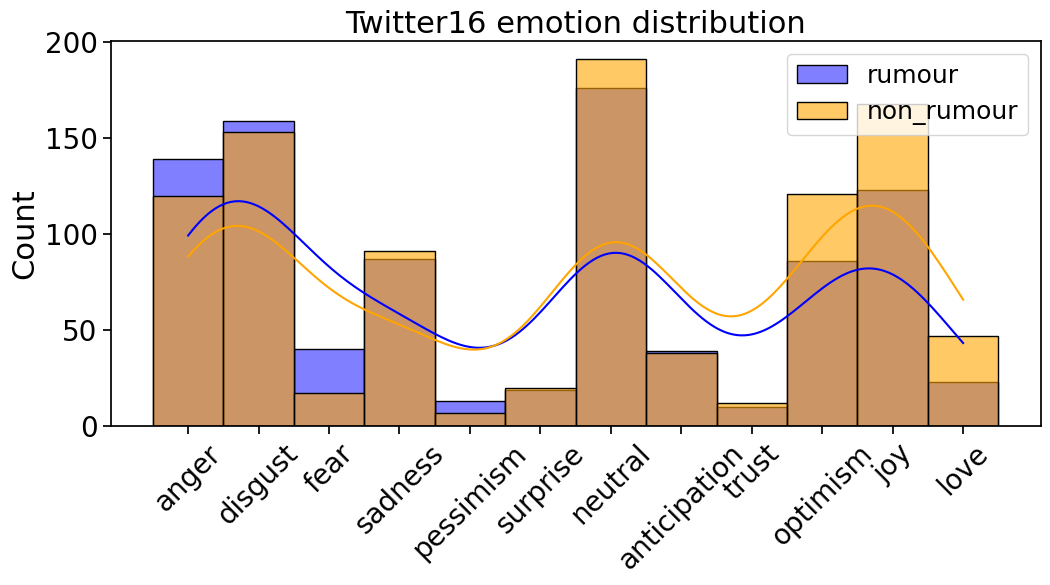

In [24]:
sns_plot2(df1=rumour_comments_emotion,df2=non_rumour_comments_emotion,size=(12,5),font_size=22,xlabels=EMO,
         title='Twitter16 emotion distribution',saveto='twitter16_emotion.pdf')

## sentiment/emotion distribution of comments

In [6]:
# filter source tweet with more than N comments
n_comments=2

df=preprocess(pd.read_csv(filename,encoding='utf-8'))
df['id']=df['id'].astype(str)
src_tweets=df[~df['structure'].str.endswith('reaction')]
src_tweets['n_comments']=src_tweets['structure'].apply(lambda x: collect_keys(x)).apply(lambda x: len(x))
src_tweets=src_tweets[src_tweets['n_comments']>=n_comments]

# sample same amount of cases for rumours and non-rumours
rumour=src_tweets[src_tweets['rumour_type']=='rumours']
non_rumour=src_tweets[src_tweets['rumour_type']=='non-rumours']

# sampling to balance data
sample_n=min(len(rumour),len(non_rumour))
rumour=rumour.sample(sample_n,random_state=2024)
non_rumour=non_rumour.sample(sample_n,random_state=2024)
print(f"rumour size:{len(rumour)}")
print(f"non rumour size:{len(non_rumour)}")

src_tweets=pd.concat([rumour,non_rumour])

rumour size:205
non rumour size:205


In [7]:
df_comments=[]
for i,(index, row) in tqdm(enumerate(src_tweets.iterrows()),total=len(src_tweets)):
    # get all comments in the source tweet thread
    structure=row['structure']
    structure_keys = collect_keys(structure)
    df_thread = df[df['id'].isin(structure_keys)]
    df_comment=df_thread[df_thread['structure'].str.endswith('reaction')] # exclude the root tweet
    df_comment['emollm_emotion']=df_comment['emollm_emotion'].apply(process_emotion)
    
    # aggregate each thread, 
    # get top3 emotion, average sentiment
    all_words = list(itertools.chain.from_iterable(df_comment['emollm_emotion']))
    top_3 = [word for word, count in Counter(all_words).most_common(MOST_COMMON)]
    ave_sentiment=df_thread['emollm_sentiment'][1:].mean()

    
    df_agg=pd.DataFrame({'id':df_thread.iloc[0]['id'],
                            'emollm_emotion':[top_3],
                            'rumour_type':df_thread.iloc[0]['rumour_type'],
                            'factuality':df_thread.iloc[0]['factuality'],
                            'emollm_sentiment':ave_sentiment})
    df_comments.append(df_agg)
df_comments=pd.concat(df_comments)

100%|████████████████████████████████████████████████████████| 410/410 [00:00<00:00, 673.69it/s]


In [8]:
df_comments['emollm_sentiment'].fillna(0,inplace=True)
df_comments[df_comments['emollm_sentiment'].isna()==True]

,id,emollm_emotion,rumour_type,factuality,emollm_sentiment


In [9]:
df_comments

,id,emollm_emotion,rumour_type,factuality,emollm_sentiment
0,544271362022338560,"[joy, optimism, love, anticipation, fear]",rumours,true,-0.333333
0,651825062174195712,"[disgust, anger, neutral, optimism, joy]",rumours,false,-0.312500
0,745236050407194624,"[joy, optimism, disgust, fear, sadness]",rumours,unverified,-0.500000
0,663817239896821760,"[joy, neutral, optimism, disgust, sadness]",rumours,false,0.166667
0,672632899921833984,"[disgust, neutral, anger, optimism, sadness]",rumours,false,-0.333333
...,...,...,...,...,...
0,689860942671130624,"[neutral, disgust, optimism, joy, anger]",non-rumours,non-rumor,-0.025641
0,688446106943008768,"[disgust, anger, sadness, joy, anticipation]",non-rumours,non-rumor,-0.521739
0,693315824132685824,"[neutral, joy, love, optimism, disgust]",non-rumours,non-rumor,0.210526
0,692890520960397312,"[joy, neutral, sadness, optimism]",non-rumours,non-rumor,0.200000


In [10]:
# tweet comments (is_rumour)
rumour_comments=df_comments[df_comments['rumour_type'].str.startswith('rumours')]
non_rumour_comments=df_comments[df_comments['rumour_type'].str.startswith('non-rumours')]
print(f"rumour size:{len(rumour_comments)}")
print(f"non rumour size:{len(non_rumour_comments)}")
print()

# tweet comments (factuality)
true_rumour_comments=rumour_comments[rumour_comments['factuality']=='true']
false_rumour_comments=rumour_comments[rumour_comments['factuality']=='false']
unverified_rumour_comments=rumour_comments[rumour_comments['factuality']=='unverified']

sample_p=min(len(true_rumour_comments),len(false_rumour_comments),len(unverified_rumour_comments))
true_rumour_comments=true_rumour_comments.sample(sample_p,random_state=2024)
false_rumour_comments=false_rumour_comments.sample(sample_p,random_state=2024)
unverified_rumour_comments=unverified_rumour_comments.sample(sample_p,random_state=2024)

print(f"true rumour size:{len(true_rumour_comments)}")
print(f"false rumour size:{len(false_rumour_comments)}")
print(f"unverified rumour size:{len(unverified_rumour_comments)}")

rumour size:205
non rumour size:205

true rumour size:66
false rumour size:66
unverified rumour size:66


In [11]:
print(f"average sentiment for rumour comments:{rumour_comments['emollm_sentiment'].mean()}")
print(f"average sentiment for non rumour comments:{non_rumour_comments['emollm_sentiment'].mean()}")
print(f"average sentiment for true rumour comments:{true_rumour_comments['emollm_sentiment'].mean()}")
print(f"average sentiment for false rumour comments:{false_rumour_comments['emollm_sentiment'].mean()}")
print(f"average sentiment for unverified rumour comments:{unverified_rumour_comments['emollm_sentiment'].mean()}")

average sentiment for rumour comments:-0.2805955984132194
average sentiment for non rumour comments:-0.12484294299392336
average sentiment for true rumour comments:-0.32465357425507274
average sentiment for false rumour comments:-0.279394978433006
average sentiment for unverified rumour comments:-0.24738244972947368


In [12]:
# conduct p-test for average sentiment
pairs=[
    (rumour_comments['emollm_sentiment'],non_rumour_comments['emollm_sentiment']),
    (true_rumour_comments['emollm_sentiment'],false_rumour_comments['emollm_sentiment']),
    (unverified_rumour_comments['emollm_sentiment'],true_rumour_comments['emollm_sentiment']),
    (unverified_rumour_comments['emollm_sentiment'],false_rumour_comments['emollm_sentiment']),
]

print(f"rumour and non-rumour sentiment t-test:")
for a, b in pairs:
    # t_stat, p_value = stats.ttest_ind(a,b)
    t_stat, p_value = stats.ttest_ind(a, b, alternative='less')
    print(f"T-statistic: {t_stat}, P-value: {p_value}")

f_stat, p_value = stats.f_oneway(true_rumour_comments['emollm_sentiment'], false_rumour_comments['emollm_sentiment'], unverified_rumour_comments['emollm_sentiment'])
print(f"\ntrue, false, unverified rumour sentiment ANOVA:")
print(f"F-statistic: {f_stat}, P-value: {p_value}")

rumour and non-rumour sentiment t-test:
T-statistic: -3.8206284143135667, P-value: 7.691951170262018e-05
T-statistic: -0.6043877789530759, P-value: 0.27331961256351245
T-statistic: 0.9514848368884115, P-value: 0.8284380071597108
T-statistic: 0.4627866026534741, P-value: 0.6778544695688109

true, false, unverified rumour sentiment ANOVA:
F-statistic: 0.5323826778933961, P-value: 0.5880552026482244


In [13]:
# tweet comments emotion distribution
rumour_comments_emotion = sorted(sum(rumour_comments['emollm_emotion'], []))
non_rumour_comments_emotion = sorted(sum(non_rumour_comments['emollm_emotion'], []))

# tweet comments emotion distribution
true_rumour_comments_emotion = sorted(sum(true_rumour_comments['emollm_emotion'], []))
false_rumour_comments_emotion = sorted(sum(false_rumour_comments['emollm_emotion'], []))
unverified_rumour_comments_emotion = sorted(sum(unverified_rumour_comments['emollm_emotion'], []))

In [14]:
print_emo_count(rumour_comments_emotion)
print_emo_count(non_rumour_comments_emotion)

negative emotions: 438
positive emotions: 300
neutral: 176

negative emotions: 388
positive emotions: 406
neutral: 191



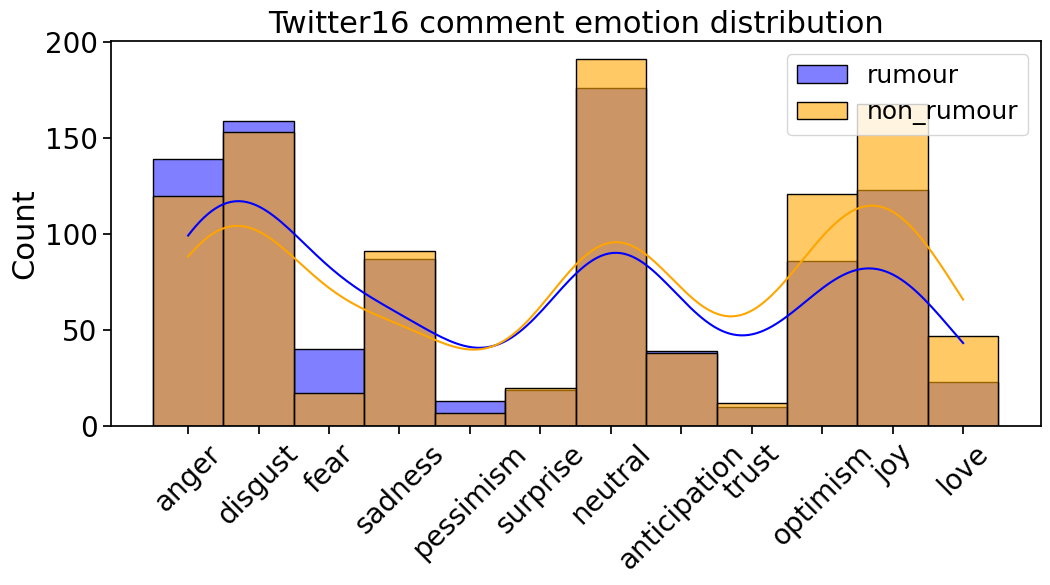

In [25]:
sns_plot2(df1=rumour_comments_emotion,df2=non_rumour_comments_emotion,size=(12,5),font_size=22,xlabels=EMO,
         title='Twitter16 comment emotion distribution',saveto='twitter16_emotion_cmt.pdf')

# emotion stream analysis

In [6]:
# filter source tweet with more than N comments
n_comments=2

df=pd.read_csv(filename,encoding='utf-8')
df['id']=df['id'].astype(str)
df[sentiment_scheme]=df[emotion_scheme].astype(str)
src_tweets=df[~df['structure'].str.endswith('reaction')]
src_tweets['n_comments']=src_tweets['structure'].apply(lambda x: collect_keys(x)).apply(lambda x: len(x))
src_tweets=src_tweets[src_tweets['n_comments']>=n_comments]

# sample same amount of cases for rumours and non-rumours
rumour=src_tweets[src_tweets['rumour_type']=='rumours']
non_rumour=src_tweets[src_tweets['rumour_type']=='non-rumours']

# sampling to balance data
sample_n=min(len(rumour),len(non_rumour))
rumour=rumour.sample(sample_n,random_state=2024)
non_rumour=non_rumour.sample(sample_n,random_state=2024)
print(f"rumour size:{len(rumour)}")
print(f"non rumour size:{len(non_rumour)}")

src_tweets=pd.concat([rumour,non_rumour])

rumour size:205
non rumour size:205


In [7]:
df_comments_original=[]
for i,(index, row) in tqdm(enumerate(src_tweets.iterrows()),total=len(src_tweets)):
    # print(row['rumour_type'])
    structure=row['structure']
    structure_keys = collect_keys(structure)
    df_thread = df[df['id'].isin(structure_keys)]
    df_thread['emollm_emotion']=df_thread['emollm_emotion'].apply(process_emotion)
    
    df_agg=pd.DataFrame({'id':df_thread.iloc[0]['id'],
                         'timestamp_emotion':[df_thread['emollm_emotion'].to_list()],
                         'rumour_type':df_thread.iloc[0]['rumour_type'],
                         'factuality':df_thread.iloc[0]['factuality'],
                        })
    df_comments_original.append(df_agg)
df_comments=pd.concat(df_comments_original)

100%|██████████████████████████████████████████████████| 410/410 [00:00<00:00, 914.53it/s]


In [8]:
# group each thread emotion according to time interval
# each row in df_comments is a thread
df_comments['interval_emotion'] = df_comments.apply(
    lambda row: calculate_interval_emotions(row['timestamp_emotion'], 1), axis=1)

In [9]:
# select thread with at least n_intervals, so far we choose n_intervals=4
n_intervals=10
accum=True
df_time=df_comments[df_comments['interval_emotion'].apply(len)>=n_intervals]
df_time['interval_cnt']=df_time['interval_emotion'].apply(lambda row: count_interval_number(row)).apply(lambda row: cut_list(row,n_intervals))

In [10]:
rumour, non_rumour=get_labeled(df_time,True)
rumour_interval_emotions=get_timestep_emotions(rumour,n_intervals,'interval_emotion')
non_rumour_interval_emotions=get_timestep_emotions(non_rumour,n_intervals,'interval_emotion')

rumour size:122
non rumour size:122


In [11]:
from utils import *

<Figure size 1000x600 with 0 Axes>

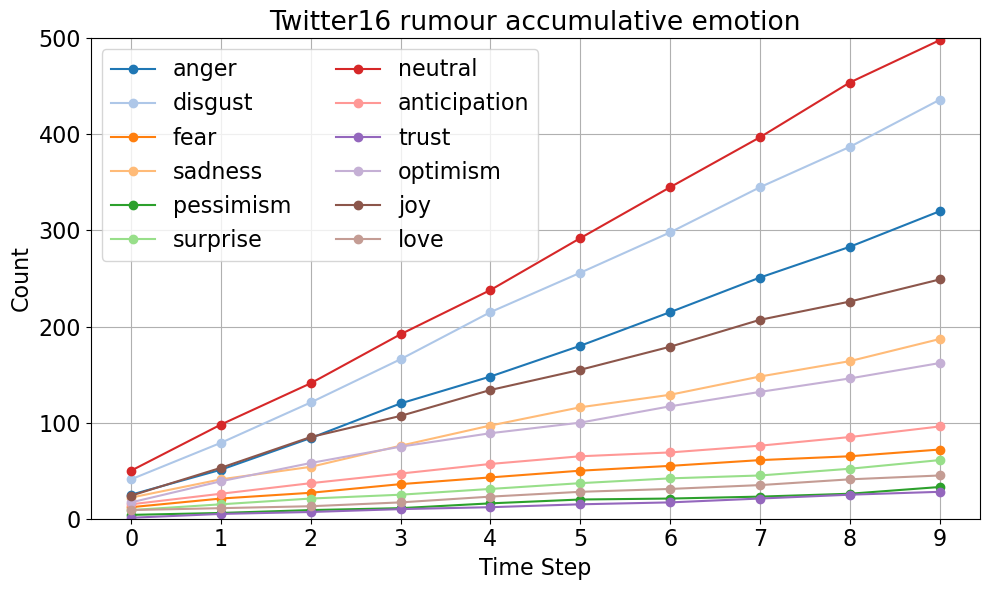

<Figure size 1000x600 with 0 Axes>

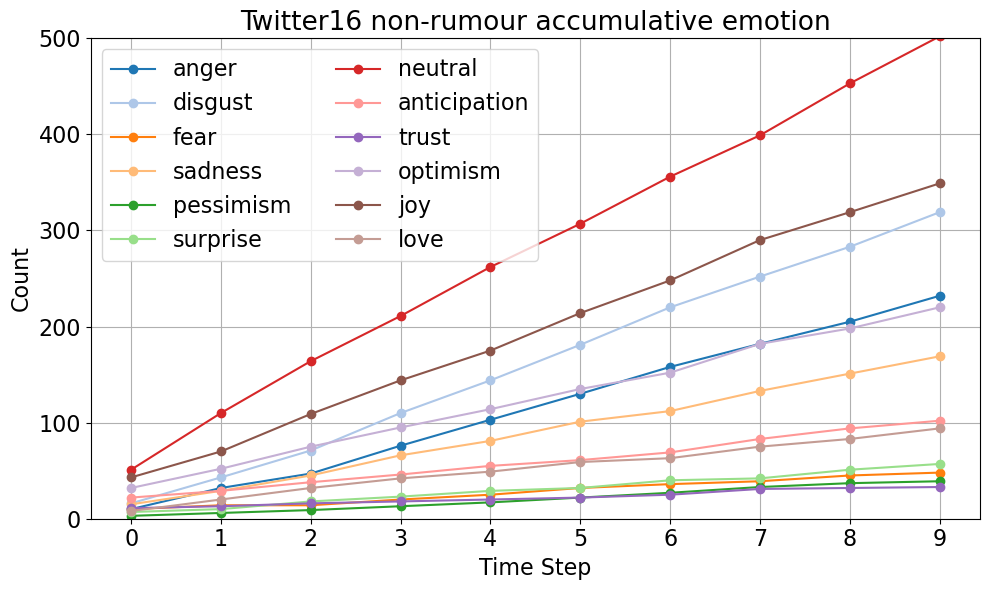

In [12]:
ru_acum=line_plot(rumour_interval_emotions,xlabel='Time Step',ylabel='Count',accum=accum,n_minutes=None, ylim=(0,500),
          title=f'Twitter16 rumour accumulative emotion',saveto=f'emotion_accumulative/twitter16_rumour_accumulative.pdf')
non_acum=line_plot(non_rumour_interval_emotions,xlabel='Time Step',ylabel='Count',accum=accum,n_minutes=None, ylim=(0,500),
          title=f'Twitter16 non-rumour accumulative emotion',saveto=f'emotion_accumulative/twitter16_non_accumulative.pdf')

In [13]:
# Combine rumour and non-rumour data into one DataFrame
def create_df(data, condition):
    emotion_data = []
    for emotion, values in data.items():
        emotion_data.append(pd.DataFrame({
            'x': values['x'],
            'y': values['y'],
            'emotion': emotion,
            'Condition': condition
        }))
    return pd.concat(emotion_data, ignore_index=True)

In [14]:
# Create DataFrames for rumour and non-rumour
ru_acum_df = create_df(ru_acum, 'rumour')
non_acum_df = create_df(non_acum, 'non-rumour')

# Combine rumour and non-rumour DataFrames
acum_df = pd.concat([ru_acum_df, non_acum_df], ignore_index=True)

# Create interaction term: x * Condition (1 if rumour, 0 if non-rumour)
acum_df['Condition'] = acum_df['Condition'].map({'rumour': 1, 'non-rumour': 0})
acum_df['x*Condition'] = acum_df['x'] * acum_df['Condition']

In [15]:
# Fit the model for each emotion
results = {}
for emotion in acum_df['emotion'].unique():
    emotion_data = acum_df[acum_df['emotion'] == emotion]
    
    # Define the independent variables (x, Condition, x*Condition) and dependent variable (y)
    X = emotion_data[['x', 'Condition', 'x*Condition']]
    X = sm.add_constant(X)  # Add constant for intercept
    y = emotion_data['y']
    
    # Fit the OLS regression model
    model = sm.OLS(y, X).fit()
    
    # Store results
    results[emotion] = model.summary()

In [16]:
# Print results for each emotion
for emotion, result in results.items():
    print(f"Results for {emotion}:\n")
    print(result)
    print("\n" + "="*50 + "\n")

Results for anger:

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     3848.
Date:                Thu, 14 Nov 2024   Prob (F-statistic):           4.49e-23
Time:                        23:45:43   Log-Likelihood:                -52.077
No. Observations:                  20   AIC:                             112.2
Df Residuals:                      16   BIC:                             116.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           4.1273      2.

In [57]:
def print_dict(sample_dict):
    for key,values in sample_dict.items():
        print(key, values)
print_dict(ru_slopes)
print()
print_dict(non_slopes)

anger 32.92
disgust 44.05
fear 6.56
sadness 18.15
pessimism 3.06
surprise 5.48
neutral 50.41
anticipation 8.55
trust 2.89
optimism 15.52
joy 24.75
love 4.19

anger 25.33
disgust 33.77
fear 4.82
sadness 18.01
pessimism 4.32
surprise 5.84
neutral 49.62
anticipation 7.98
trust 2.59
optimism 20.1
joy 33.98
love 10.16


# sentiments & emotion transition
- extract non-root pairwise emotions: return a list of (parent emotion, child emotion)
- extract root pairwise emotions: return a list of (root emotion, first layer node emotions)
- build count-based emotion transition matrix
- build masking emotion

In [15]:
# sentiment_scheme='emollm_sentiment'
emotion_scheme='emollm_emotion'

In [16]:
# filter source tweet with more than N comments
n_comments=2

df=pd.read_csv(filename,encoding='utf-8')
df['id']=df['id'].astype(str)
df[sentiment_scheme]=df[emotion_scheme].astype(str)
src_tweets=df[~df['structure'].str.endswith('reaction')]
src_tweets['n_comments']=src_tweets['structure'].apply(lambda x: collect_keys(x)).apply(lambda x: len(x))
src_tweets=src_tweets[src_tweets['n_comments']>=n_comments]

# sample same amount of cases for rumours and non-rumours
rumour=src_tweets[src_tweets['rumour_type']=='rumours']
non_rumour=src_tweets[src_tweets['rumour_type']=='non-rumours']

# sampling to balance data
sample_n=min(len(rumour),len(non_rumour))
rumour=rumour.sample(sample_n,random_state=2024)
non_rumour=non_rumour.sample(sample_n,random_state=2024)
print(f"rumour size:{len(rumour)}")
print(f"non rumour size:{len(non_rumour)}")

src_tweets=pd.concat([rumour,non_rumour])

rumour size:205
non rumour size:205


In [17]:
df_comments_original=[]
# thread or time
pairwise_type='time'
n_gram=5
for index, row in tqdm(src_tweets.iterrows(),total=src_tweets.shape[0]):
    # print(row['rumour_type'])
    structure=row['structure']
    structure_keys = collect_keys(structure)
    df_thread = df[df['id'].isin(structure_keys)]
    df_thread=df_thread.drop_duplicates(subset=['id'], keep='first')
    # df_thread[emotion_scheme]=df_thread[emotion_scheme].apply(process_emotion,primary=False)
    # df_thread['created_at']=df_thread['created_at'].apply(format_time)
    # df_thread.sort_values(by='created_at',inplace=True)

    # aggregate information for one thread
    agg_dict={
        'id':df_thread.iloc[0]['id'],
        # 'event':df_thread.iloc[0]['event'],
        'rumour_type':df_thread.iloc[0]['rumour_type'],
        'factuality':df_thread.iloc[0]['factuality'],
    }
    # extract N-gram affective info (the first in N-gram should be aff in source tweet)
    if 'n_gram' in pairwise_type:
        df_thread[emotion_scheme]=df_thread[emotion_scheme].apply(process_emotion,primary=True)
        n_gram_id=timestamp_n_gram(df_thread['id'].to_list(),n_gram,False)
        n_gram_emo=get_aff_from_id(df_thread,n_gram_id,emotion_scheme)
        agg_dict.update({
            'n_gram_pairs_id':[n_gram_id],
            'n_gram_pairs_emo':[n_gram_emo],
        })

    # extract pair affective info chronologically
    if 'time' in pairwise_type:
        df_thread[emotion_scheme]=df_thread[emotion_scheme].apply(process_emotion,primary=False)
        df_thread=df_thread[df_thread['structure'].str.endswith('reaction')] # exclude the root tweet
        time_pairs_id=timestamp_pairwise(df_thread['id'].to_list())
        time_pairs_emo=get_emo_from_id(df_thread,time_pairs_id)
        time_pairs_emo=product_pairs(time_pairs_emo)
        time_pairs_sent=get_sent_from_id(df_thread,time_pairs_id)
        agg_dict.update({
            'time_pairs_id':[time_pairs_id],
            'time_pairs_emo':[time_pairs_emo],
            'time_pairs_sent':[time_pairs_sent],
        })
        
    # extract pair affective info based on tree structure
    if 'thread' in pairwise_type:
        df_thread[emotion_scheme]=df_thread[emotion_scheme].apply(process_emotion,primary=False)
        # extract pariwise ids, (parent, child) comes from structure
        _, non_root_pairs, root_pairs=bfs_tree_pairwise(structure)
        
        # extract pairwise emotions from ids
        root_pairs_emo=get_emo_from_id(df_thread,root_pairs)
        non_root_pairs_emo=get_emo_from_id(df_thread,non_root_pairs)
        # product pairs
        root_pairs_emo=product_pairs(root_pairs_emo)
        non_root_pairs_emo=product_pairs(non_root_pairs_emo)
    
        # extract pairwise sentiments from ids
        root_pairs_sent=get_sent_from_id(df_thread,root_pairs)
        non_root_pairs_sent=get_sent_from_id(df_thread,non_root_pairs)
        agg_dict.update({
            'root_pairs_id':[root_pairs],
            'non_root_pairs_id':[non_root_pairs],
            'root_pairs_emo':[root_pairs_emo],
            'non_root_pairs_emo':[non_root_pairs_emo],
            'root_pairs_sent':[root_pairs_sent],
            'non_root_pairs_sent':[non_root_pairs_sent],
        })
    
    df_agg=pd.DataFrame(agg_dict)
    df_comments_original.append(df_agg)

100%|█████████████████████████████████████████████████████████| 410/410 [00:04<00:00, 87.34it/s]


In [18]:
df_comments=pd.concat(df_comments_original)

In [19]:
df_comments.head()

,id,rumour_type,factuality,time_pairs_id,time_pairs_emo,time_pairs_sent
0,544271362022338560,rumours,true,"[(544271362022338560_1, 544271362022338560_2),...","[(joy, anticipation), (joy, fear), (joy, joy),...","[( joy, love, optimism., anticipation, fear, ..."
0,651825062174195712,rumours,false,"[(651825062174195712_1, 651825062174195712_2),...","[(joy, anger), (joy, disgust), (joy, sadness),...","[( joy, optimism, trust., anger, disgust, sad..."
0,745236050407194624,rumours,unverified,"[(745236050407194624_1, 745236050407194624_2)]","[(joy, disgust), (joy, fear), (joy, sadness), ...","[( joy, optimism., disgust, fear, sadness, su..."
0,663817239896821760,rumours,false,"[(663817239896821760_1, 663817239896821760_2),...","[(neutral, joy), (neutral, optimism), (joy, ne...","[( neutral or no emotion., joy, optimism.), (..."
0,672632899921833984,rumours,false,"[(672632899921833984_1, 672632899921833984_2),...","[(neutral, anger), (neutral, disgust), (anger,...","[( neutral or no emotion., anger, disgust.), ..."


In [20]:
rumour, non_rumour=get_labeled(df_comments,True)

rumour size:205
non rumour size:205


In [21]:
true, false, unverified= get_factuality(df_comments,True)

true size:66
false size:66
unverified size:66


## emotion transition (time)

In [22]:
# rumour and non rumour emotion
sample_size=0
no_neutral=False
is_log=False
ru_root=get_emo_pairs(rumour,'time_pairs_emo',no_neutral,sample_size)
non_root=get_emo_pairs(non_rumour,'time_pairs_emo',no_neutral,sample_size)

time_pairs_emo pair size: 11599
time_pairs_emo pair size: 21448


In [25]:
from utils import *

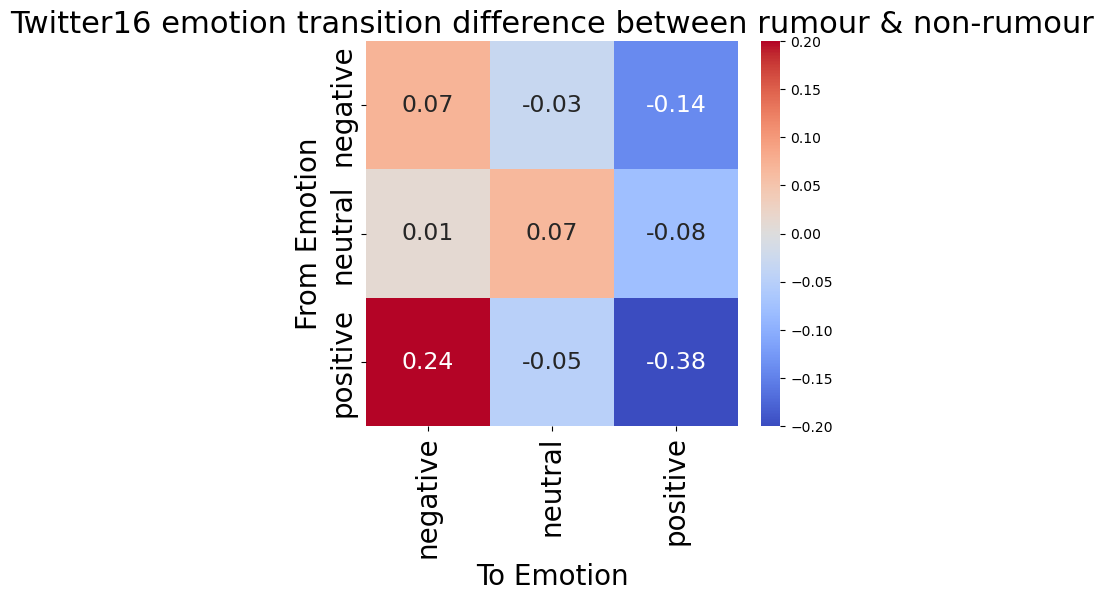

In [26]:
# aggregated emotions
vmax=0.2
vmin=-0.2
font_size=16
_,ru_root_matrix=create_pure_matrix(normalize_emotion_pairs(ru_root),'emo_agg',no_neutral,is_log,'twitter16_rumour_transition',vmax,vmin)
_,non_root_matrix=create_pure_matrix(normalize_emotion_pairs(non_root),'emo_agg',no_neutral,is_log,'twitter16_non_transition',vmax,vmin)
diff_root=(ru_root_matrix-non_root_matrix)/ru_root_matrix

plot_matrix(matrix=diff_root,aff='emo_agg',no_neutral=False,font_size=20,vmax=vmax,vmin=vmin, annot=diff_root, fig_size=(6,5),
            title='Twitter16 emotion transition difference between rumour & non-rumour')

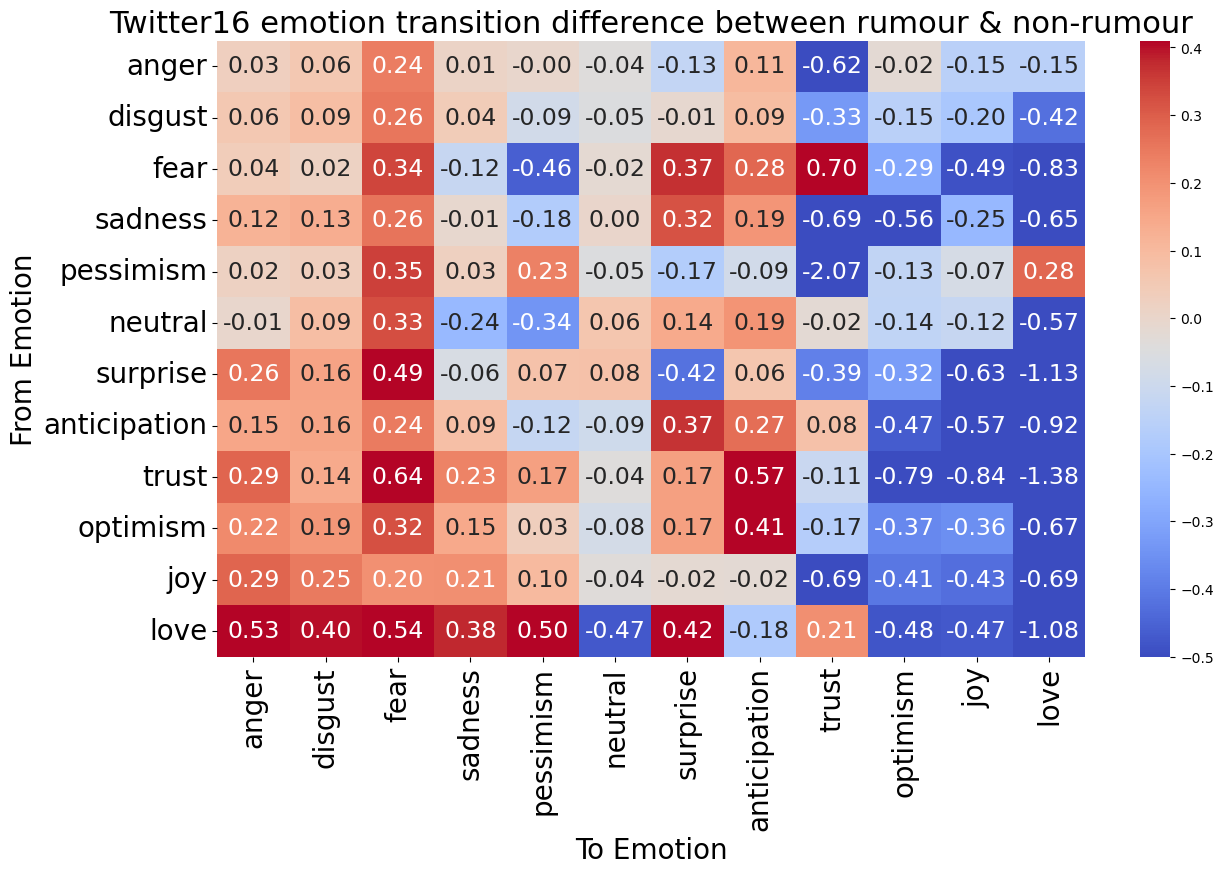

In [27]:
vmax=0.41
vmin=-0.5
font_size=16
_,ru_root_matrix=create_pure_matrix(ru_root,'emo',no_neutral,is_log,'twitter16_rumour_transition',vmax,vmin)
_,non_root_matrix=create_pure_matrix(non_root,'emo',no_neutral,is_log,'twitter16_non_transition',vmax,vmin)
diff_root=(ru_root_matrix-non_root_matrix)/ru_root_matrix
plot_matrix(diff_root,aff='emo',no_neutral=no_neutral,font_size=20,vmax=vmax,vmin=vmin, annot=diff_root,
            title='Twitter16 emotion transition difference between rumour & non-rumour',saveto='twitter16_diff_transition_noroot.pdf')

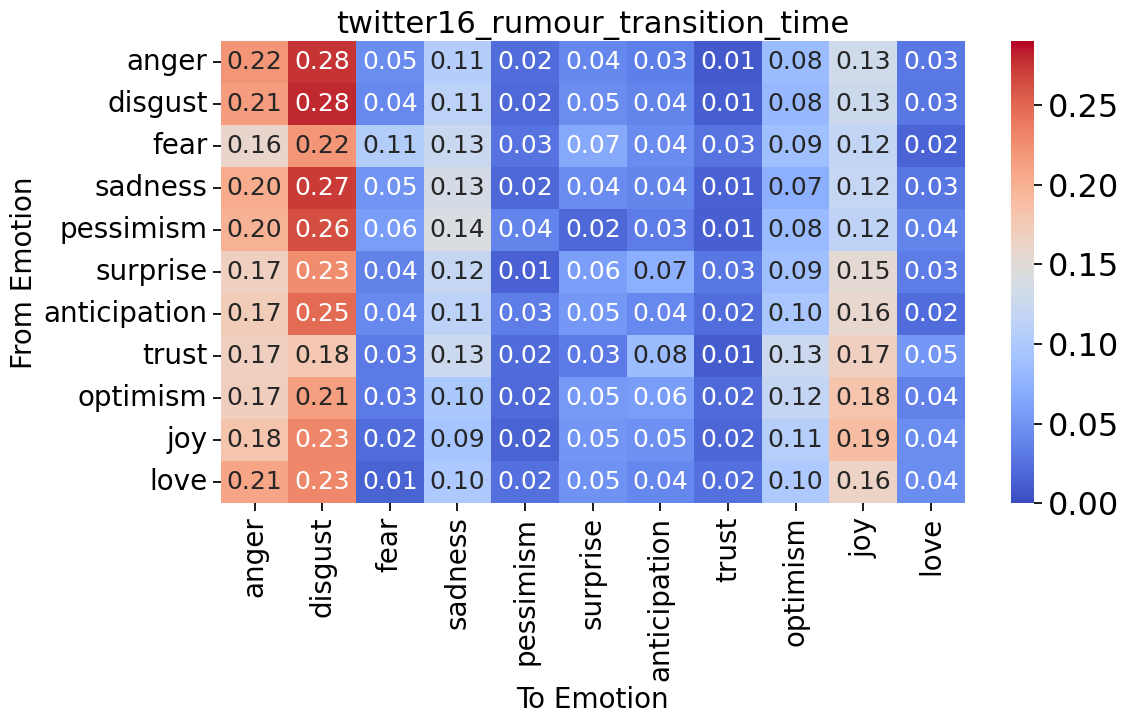

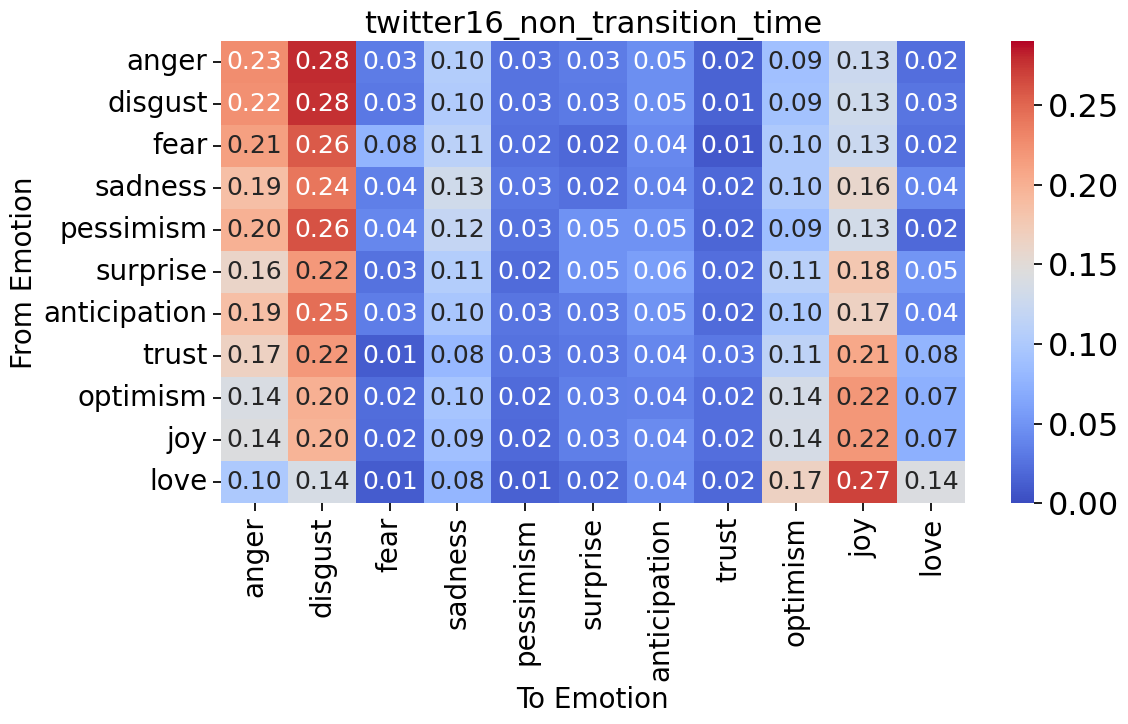

In [41]:
# rumour vs non rumour root
vmax=0.29
vmin=0
font_size=16
create_matrix(ru_root,'emo',no_neutral,is_log,'twitter16_rumour_transition_time',vmax,vmin)
create_matrix(non_root,'emo',no_neutral,is_log,'twitter16_non_transition_time',vmax,vmin)

In [ ]:
# rumour and non rumour emotion
sample_size=0
no_neutral=True
is_log=False
ru_root=get_emo_pairs(rumour,'n_gram_pairs_emo',sample_size)
non_root=get_emo_pairs(non_rumour,'n_gram_pairs_emo',sample_size)

In [53]:
# sentiment_scheme='emollm_sentiment'
emotion_scheme='emollm_emotion'

In [35]:
# filter source tweet with more than N comments
n_comments=0

df=preprocess(pd.read_csv(filename,encoding='utf-8'))
df['id']=df['id'].astype(str)
df[sentiment_scheme]=df[sentiment_scheme].astype(str)
src_tweets=df[~df['structure'].str.endswith('reaction')]
src_tweets['n_comments']=src_tweets['structure'].apply(lambda x: collect_keys(x)).apply(lambda x: len(x))
src_tweets=src_tweets[src_tweets['n_comments']>=n_comments]

# sample same amount of cases for rumours and non-rumours
rumour=src_tweets[src_tweets['rumour_type']=='rumours']
non_rumour=src_tweets[src_tweets['rumour_type']=='non-rumours']

# sampling to balance data
sample_n=min(len(rumour),len(non_rumour))
rumour=rumour.sample(sample_n,random_state=2024)
non_rumour=non_rumour.sample(sample_n,random_state=2024)
print(f"rumour size:{len(rumour)}")
print(f"non rumour size:{len(non_rumour)}")

src_tweets=pd.concat([rumour,non_rumour])

rumour size:205
non rumour size:205


In [36]:
df_comments_original=[]
# thread or time
pairwise_type='time'
n_gram=5
for index, row in tqdm(src_tweets.iterrows(),total=src_tweets.shape[0]):
    # print(row['rumour_type'])
    structure=row['structure']
    structure_keys = collect_keys(structure)
    df_thread = df[df['id'].isin(structure_keys)]
    df_thread=df_thread.drop_duplicates(subset=['id'], keep='first')
    # df_thread[emotion_scheme]=df_thread[emotion_scheme].apply(process_emotion,primary=False)
    # df_thread['created_at']=df_thread['created_at'].apply(format_time)
    # df_thread.sort_values(by='created_at',inplace=True)

    # aggregate information for one thread
    agg_dict={
        'id':df_thread.iloc[0]['id'],
        # 'event':df_thread.iloc[0]['event'],
        'rumour_type':df_thread.iloc[0]['rumour_type'],
        'factuality':df_thread.iloc[0]['factuality'],
    }
    # extract N-gram affective info (the first in N-gram should be aff in source tweet)
    if 'n_gram' in pairwise_type:
        df_thread[emotion_scheme]=df_thread[emotion_scheme].apply(process_emotion,primary=True)
        n_gram_id=timestamp_n_gram(df_thread['id'].to_list(),n_gram,False)
        n_gram_emo=get_aff_from_id(df_thread,n_gram_id,emotion_scheme)
        agg_dict.update({
            'n_gram_pairs_id':[n_gram_id],
            'n_gram_pairs_emo':[n_gram_emo],
        })

    # extract pair affective info chronologically
    if 'time' in pairwise_type:
        df_thread[emotion_scheme]=df_thread[emotion_scheme].apply(process_emotion,primary=False)
        time_pairs_id=timestamp_pairwise(df_thread['id'].to_list())
        time_pairs_emo=get_emo_from_id(df_thread,time_pairs_id)
        time_pairs_emo=product_pairs(time_pairs_emo)
        time_pairs_sent=get_sent_from_id(df_thread,time_pairs_id)
        agg_dict.update({
            'time_pairs_id':[time_pairs_id],
            'time_pairs_emo':[time_pairs_emo],
            'time_pairs_sent':[time_pairs_sent],
        })
        
    # extract pair affective info based on tree structure
    if 'thread' in pairwise_type:
        df_thread[emotion_scheme]=df_thread[emotion_scheme].apply(process_emotion,primary=False)
        # extract pariwise ids, (parent, child) comes from structure
        _, non_root_pairs, root_pairs=bfs_tree_pairwise(structure)
        
        # extract pairwise emotions from ids
        root_pairs_emo=get_emo_from_id(df_thread,root_pairs)
        non_root_pairs_emo=get_emo_from_id(df_thread,non_root_pairs)
        # product pairs
        root_pairs_emo=product_pairs(root_pairs_emo)
        non_root_pairs_emo=product_pairs(non_root_pairs_emo)
    
        # extract pairwise sentiments from ids
        root_pairs_sent=get_sent_from_id(df_thread,root_pairs)
        non_root_pairs_sent=get_sent_from_id(df_thread,non_root_pairs)
        agg_dict.update({
            'root_pairs_id':[root_pairs],
            'non_root_pairs_id':[non_root_pairs],
            'root_pairs_emo':[root_pairs_emo],
            'non_root_pairs_emo':[non_root_pairs_emo],
            'root_pairs_sent':[root_pairs_sent],
            'non_root_pairs_sent':[non_root_pairs_sent],
        })
    
    df_agg=pd.DataFrame(agg_dict)
    df_comments_original.append(df_agg)
df_comments=pd.concat(df_comments_original)

100%|███████████████████████████████████████████████████████████| 410/410 [00:04<00:00, 85.17it/s]


In [37]:
df_comments.head()

,id,rumour_type,factuality,time_pairs_id,time_pairs_emo,time_pairs_sent
0,552834961762709505,rumours,true,"[(552834961762709505, 552834961762709505_1), (...","[(anger, neutral), (anticipation, neutral), (d...","[(0, 0), (0, -2), (-2, 0)]"
0,651044059222556674,rumours,unverified,"[(651044059222556674, 651044059222556674_1), (...","[(anticipation, disgust), (anticipation, joy),...","[(2, 0), (0, 0), (0, 0), (0, 1), (1, 0), (0, -..."
0,647169726158925824,rumours,false,"[(647169726158925824, 647169726158925824_1), (...","[(neutral, anger), (neutral, disgust), (anger,...","[(0, 0), (0, 1), (1, 1), (1, 0), (0, 0), (0, 0..."
0,722885778448121857,rumours,unverified,"[(722885778448121857, 722885778448121857_1), (...","[(joy, neutral), (love, neutral), (optimism, n...","[(1, 0), (0, 0), (0, 0), (0, 0), (0, -2), (-2,..."
0,763428684850094080,rumours,unverified,"[(763428684850094080, 763428684850094080_1), (...","[(anger, joy), (anger, trust), (disgust, joy),...","[(-1, 0), (0, -1), (-1, 0), (0, 0), (0, 0), (0..."


In [38]:
rumour, non_rumour=get_labeled(df_comments,True)
true, false, unverified= get_factuality(df_comments,True)

rumour size:205
non rumour size:205
true size:63
false size:63
unverified size:63


In [ ]:
# rumour and non rumour emotion
sample_size=0
no_neutral=True
is_log=False
ru_root=get_sent_pairs(rumour,'root_pairs_sent',sample_size)
ru_branch=get_sent_pairs(rumour,'non_root_pairs_sent',sample_size)
non_root=get_sent_pairs(non_rumour,'root_pairs_sent',sample_size)
non_branch=get_sent_pairs(non_rumour,'non_root_pairs_sent',sample_size)

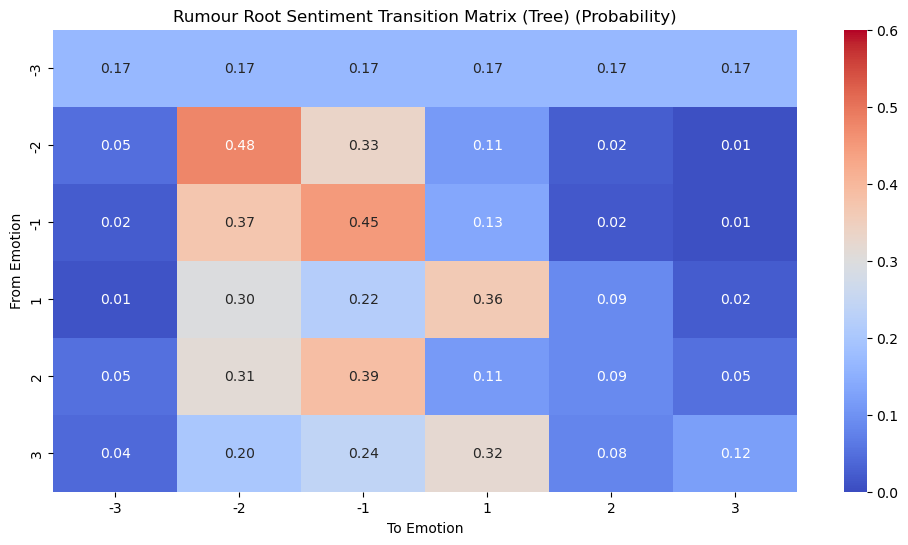

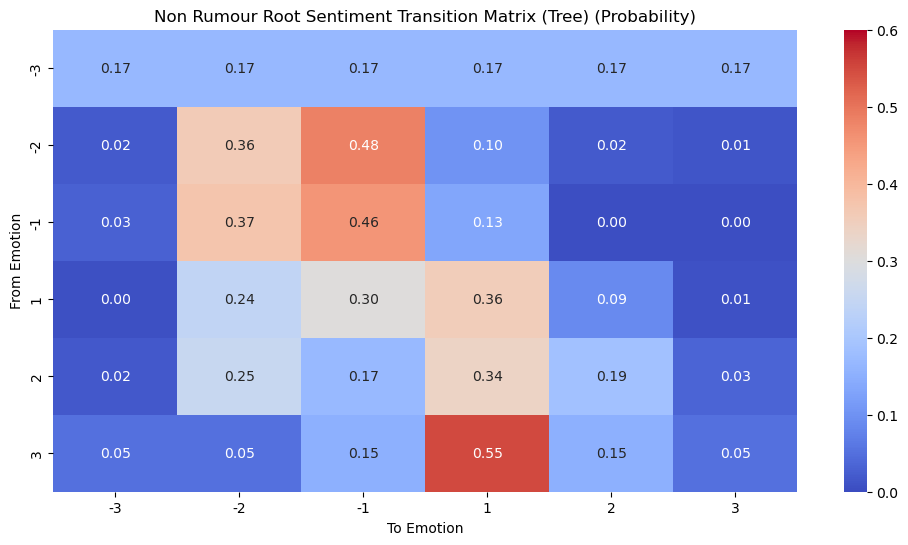

In [72]:
# rumour vs non rumour root
vmax=0.60
vmin=0
create_matrix(ru_root,'sent',no_neutral,is_log,'Rumour Root Sentiment Transition Matrix (Tree)',vmax,vmin)
create_matrix(non_root,'sent',no_neutral,is_log,'Non Rumour Root Sentiment Transition Matrix (Tree)',vmax,vmin)

In [ ]:
# rumour vs non rumour branch
create_matrix(ru_branch,'sent',no_neutral,is_log,'Rumour Branch Sentiment Transition Matrix (Tree)',vmax,vmin)
create_matrix(non_branch,'sent',no_neutral,is_log,'Non Rumour Branch Sentiment Transition Matrix (Tree)',vmax,vmin)

In [73]:
# true, false and unverified emotion
sample_size=0
true_root=get_sent_pairs(true,pair_type='root_pairs_sent',n_sample=sample_size)
false_root=get_sent_pairs(false,pair_type='root_pairs_sent',n_sample=sample_size)
unverified_root=get_sent_pairs(unverified,pair_type='root_pairs_sent',n_sample=sample_size)

true_branch=get_sent_pairs(true,pair_type='non_root_pairs_sent',n_sample=sample_size)
false_branch=get_sent_pairs(false,pair_type='non_root_pairs_sent',n_sample=sample_size)
unverified_branch=get_sent_pairs(unverified,pair_type='non_root_pairs_sent',n_sample=sample_size)

root_pairs_sent pair size: 174
root_pairs_sent pair size: 157
root_pairs_sent pair size: 138
non_root_pairs_sent pair size: 0
non_root_pairs_sent pair size: 0
non_root_pairs_sent pair size: 0


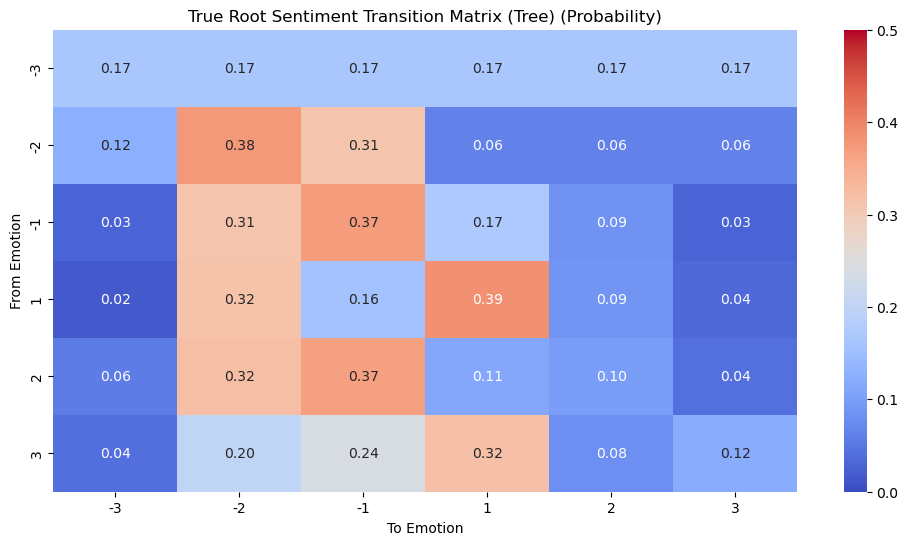

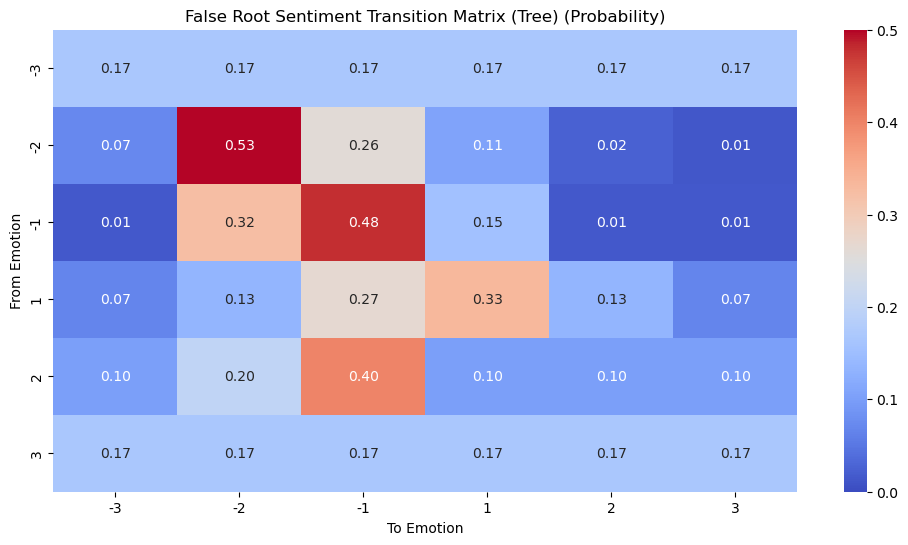

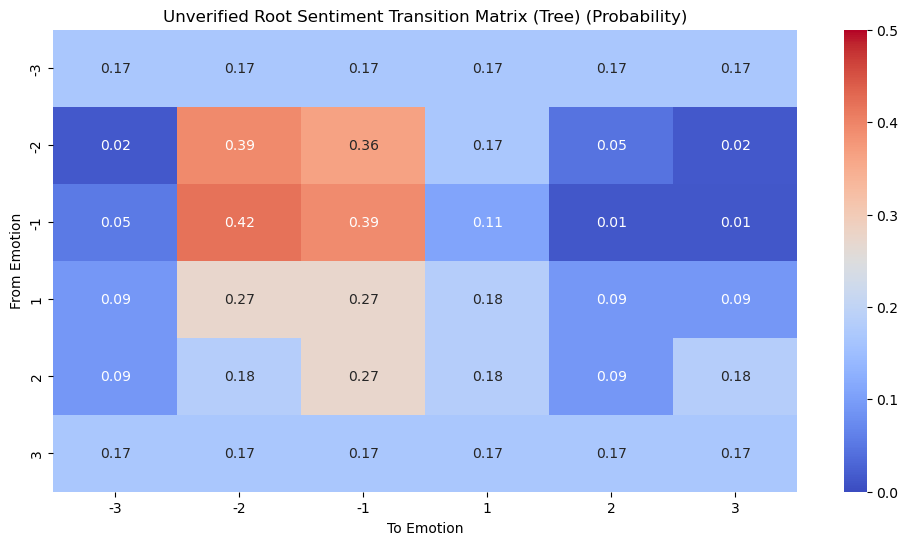

In [74]:
# true, false and unverified root
vmax=0.5
vmin=0
create_matrix(true_root,'sent',no_neutral,is_log,'True Root Sentiment Transition Matrix (Tree)',vmax,vmin)
create_matrix(false_root,'sent',no_neutral,is_log,'False Root Sentiment Transition Matrix (Tree)',vmax,vmin)
create_matrix(unverified_root,'sent',no_neutral,is_log,'Unverified Root Sentiment Transition Matrix (Tree)',vmax,vmin)

In [ ]:
# true, false and unverified branch
vmax=0.65
create_matrix(true_branch,'sent',no_neutral,is_log,'True Branch Sentiment Transition Matrix (Tree)',vmax,vmin)
create_matrix(false_branch,'sent',no_neutral,is_log,'False Branch Sentiment Transition Matrix (Tree)',vmax,vmin)
create_matrix(unverified_branch,'sent',no_neutral,is_log,'Unverified Branch Sentiment Transition Matrix (Tree)',vmax,vmin)

## emotion transition (tree)

In [55]:
# rumour and non rumour emotion
sample_size=0
no_neutral=True
is_log=False
ru_root=get_emo_pairs(rumour,'root_pairs_emo',no_neutral,sample_size)
ru_branch=get_emo_pairs(rumour,'non_root_pairs_emo',no_neutral,sample_size)
non_root=get_emo_pairs(non_rumour,'root_pairs_emo',no_neutral,sample_size)
non_branch=get_emo_pairs(non_rumour,'non_root_pairs_emo',no_neutral,sample_size)

root_pairs_emo pair size: 7059
non_root_pairs_emo pair size: 0
root_pairs_emo pair size: 12694
non_root_pairs_emo pair size: 0


In [75]:
from utils import *

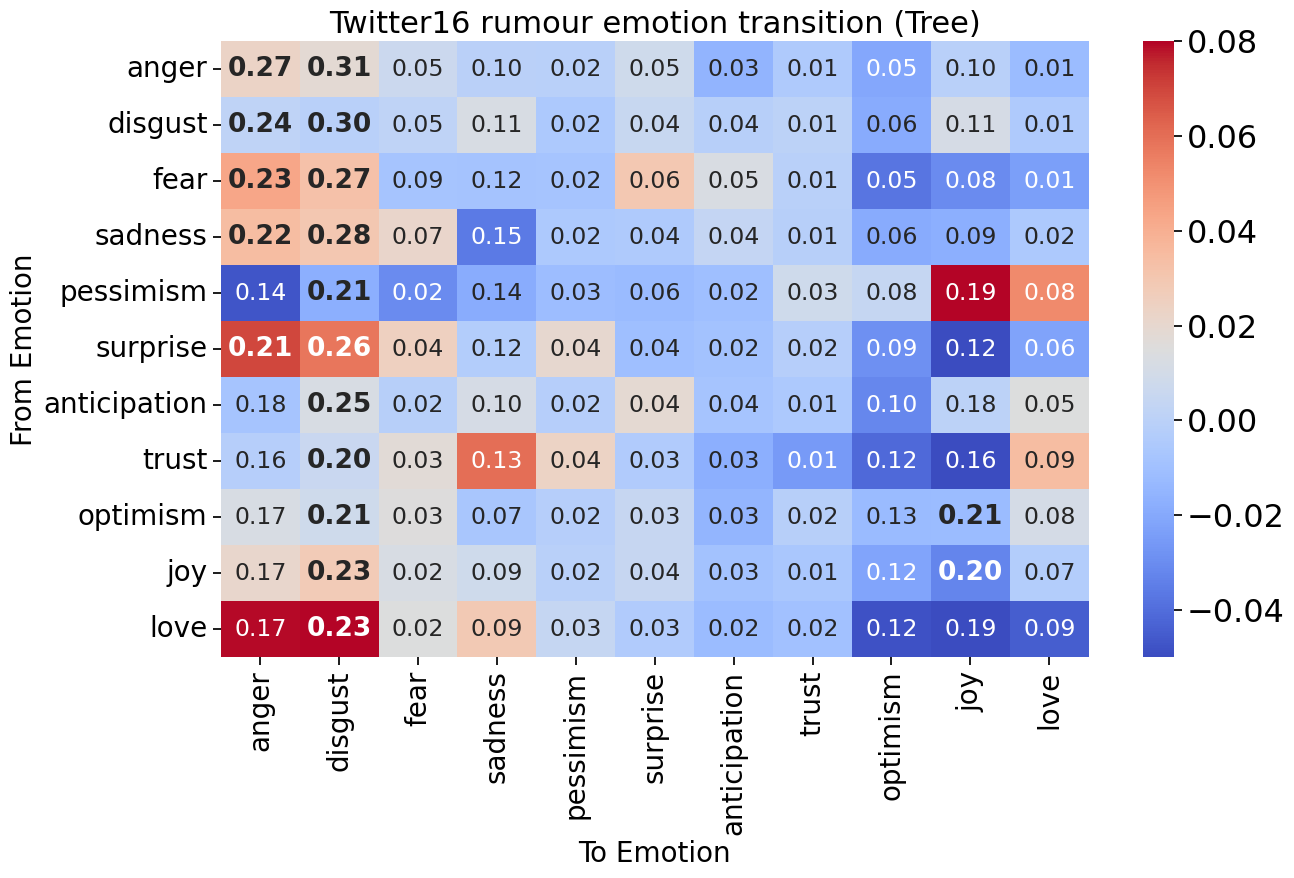

In [76]:
vmax=0.08
vmin=-0.05
font_size=16
all_ru=ru_root+ru_branch
all_non=non_root+non_branch

_,ru_matrix=create_pure_matrix(all_ru,'emo',no_neutral,is_log,'twitter16_rumour_transition',vmax,vmin)
_,non_matrix=create_pure_matrix(all_non,'emo',no_neutral,is_log,'twitter16_non_transition',vmax,vmin)

diff=ru_matrix-non_matrix

plot_matrix(matrix=diff,aff='emo',no_neutral=True,font_size=20,vmax=vmax,vmin=vmin,annot=ru_matrix,
            title='Twitter16 rumour emotion transition (Tree)',saveto='twitter16_diff_transition_tree_delta.pdf')

# plot_matrix(matrix=ru_matrix,aff='emo',no_neutral=True,font_size=20,vmax=vmax,vmin=vmin,annot=diff,
#             title='Twitter16 rumour emotion transition (Tree)',saveto='twitter16_diff_transition_tree_origin.pdf')

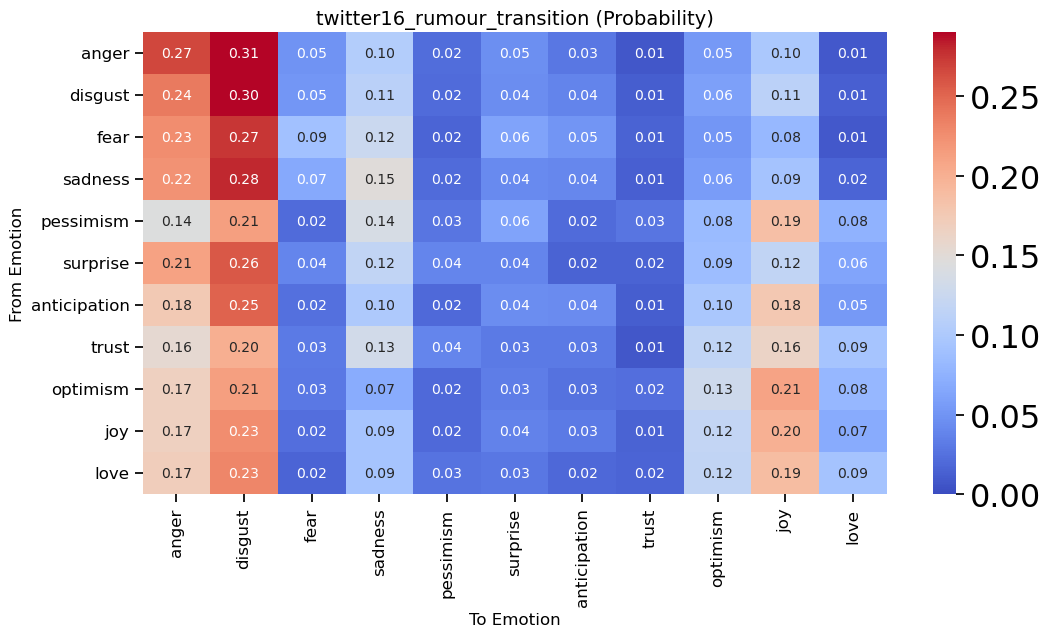

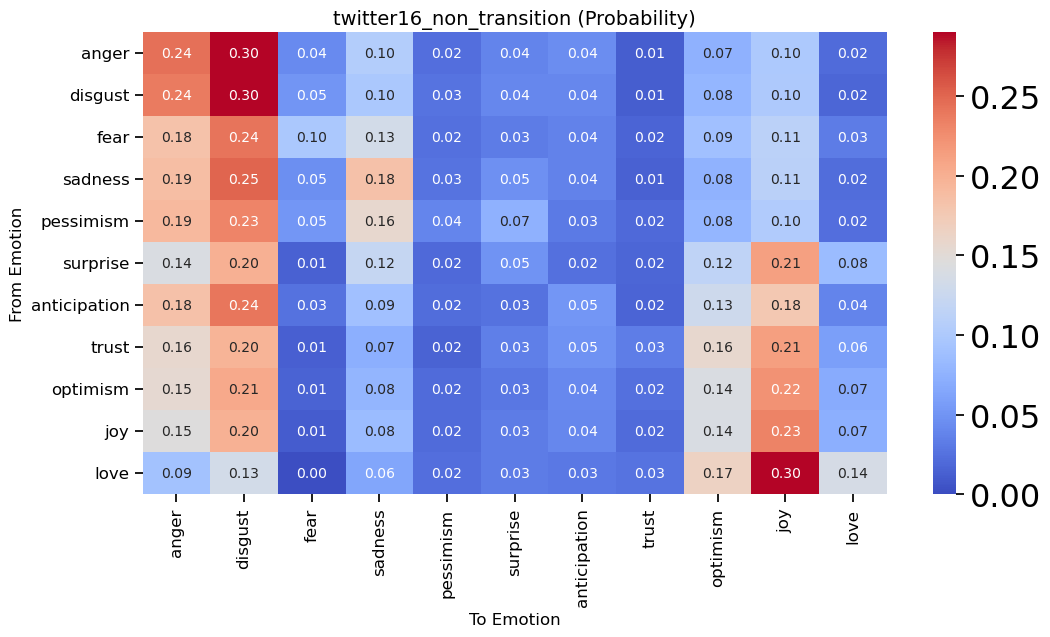

In [107]:
# rumour vs non rumour root
vmax=0.29
vmin=0
font_size=16
create_matrix(ru_root,'emo',no_neutral,is_log,'twitter16_rumour_transition',vmax,vmin)
create_matrix(non_root,'emo',no_neutral,is_log,'twitter16_non_transition',vmax,vmin)

In [ ]:
# rumour vs non rumour branch
vmax=0.32
create_matrix(ru_branch,'emo',no_neutral,is_log,'Rumour Branch Emotion Transition Matrix (Tree)',vmax,vmin)
create_matrix(non_branch,'emo',no_neutral,is_log,'Non Rumour Branch Emotion Transition Matrix (Tree)',vmax,vmin)

In [77]:
# true, false and unverified emotion
sample_size=0
true_root=get_emo_pairs(true,pair_type='root_pairs_emo',n_sample=sample_size)
false_root=get_emo_pairs(false,pair_type='root_pairs_emo',n_sample=sample_size)
unverified_root=get_emo_pairs(unverified,pair_type='root_pairs_emo',n_sample=sample_size)

true_branch=get_emo_pairs(true,pair_type='non_root_pairs_emo',n_sample=sample_size)
false_branch=get_emo_pairs(false,pair_type='non_root_pairs_emo',n_sample=sample_size)
unverified_branch=get_emo_pairs(unverified,pair_type='non_root_pairs_emo',n_sample=sample_size)

root_pairs_emo pair size: 2466
root_pairs_emo pair size: 2050
root_pairs_emo pair size: 2183
non_root_pairs_emo pair size: 0
non_root_pairs_emo pair size: 0
non_root_pairs_emo pair size: 0


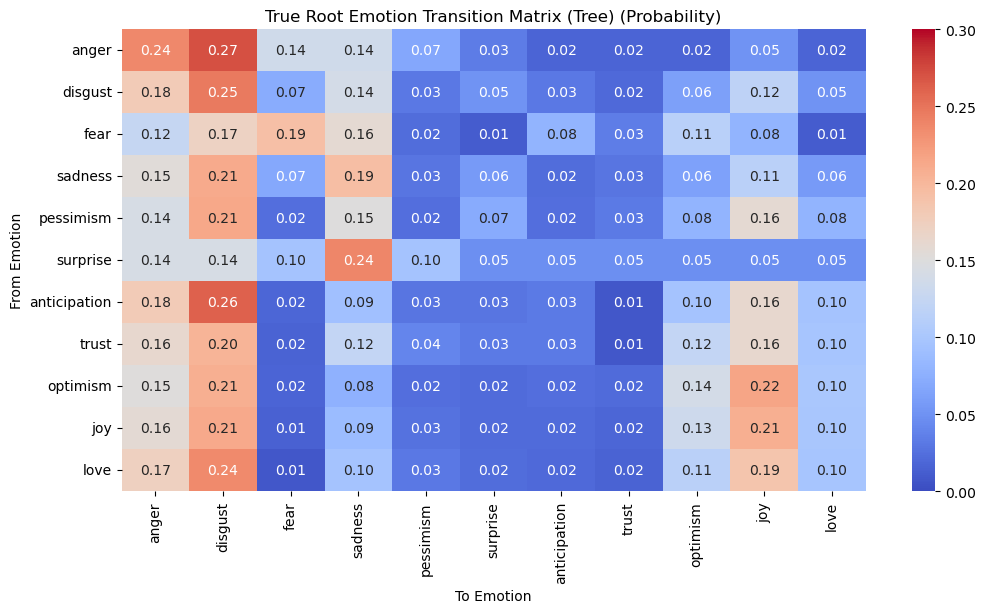

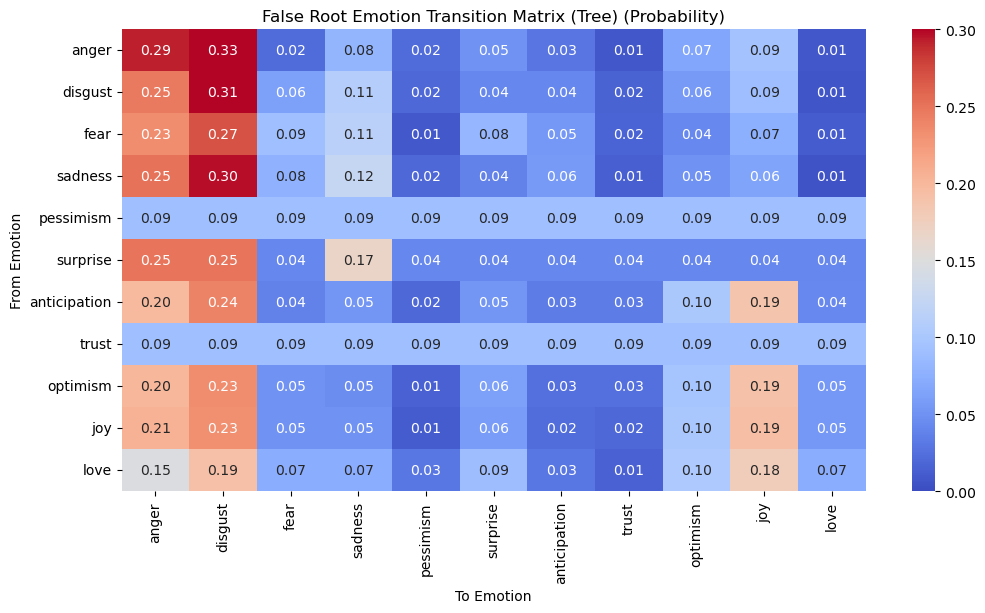

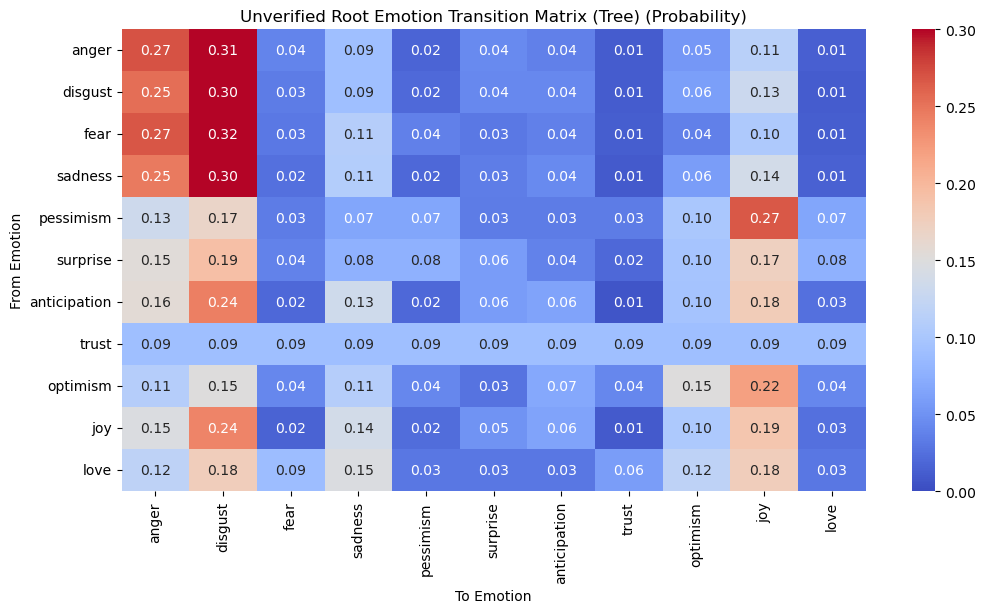

In [78]:
# true, false and unverified root
vmax=0.30
create_matrix(true_root,'emo',no_neutral,is_log,'True Root Emotion Transition Matrix (Tree)',vmax,vmin)
create_matrix(false_root,'emo',no_neutral,is_log,'False Root Emotion Transition Matrix (Tree)',vmax,vmin)
create_matrix(unverified_root,'emo',no_neutral,is_log,'Unverified Root Emotion Transition Matrix (Tree)',vmax,vmin)

In [ ]:
# true, false and unverified branch
vmax=0.32
create_matrix(true_branch,'emo',no_neutral,is_log,'True Branch Emotion Transition Matrix (Tree)',vmax,vmin)
create_matrix(false_branch,'emo',no_neutral,is_log,'False Branch Emotion Transition Matrix (Tree)',vmax,vmin)
create_matrix(unverified_branch,'emo',no_neutral,is_log,'Unverified Branch Emotion Transition Matrix (Tree)',vmax,vmin)

# Test

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Example data
data = {
    'source': {'text': 'Source Tweet', 'emotion': 'neutral', 'time': 0},
    'comments': [
        {'id': 'c1', 'text': 'Comment 1', 'emotion': 'happy', 'time': 0.5, 'reply_to': 'source'},
        {'id': 'c2', 'text': 'Comment 2', 'emotion': 'sad', 'time': 1.0, 'reply_to': 'source'},
        {'id': 'c3', 'text': 'Comment 3', 'emotion': 'angry', 'time': 1.5, 'reply_to': 'c1'},
        # Add more comments as needed
    ]
}

# Create the graph
G = nx.DiGraph()

# Add nodes
G.add_node('source', emotion='neutral', time=0)

for comment in data['comments']:
    G.add_node(comment['id'], emotion=comment['emotion'], time=comment['time'])
    G.add_edge(comment['reply_to'], comment['id'])

# Define colors for each emotion
emotion_colors = {
    'neutral': 'green',
    'happy': 'blue',
    'sad': 'red',
    'angry': 'black',
    # Add more emotions as needed
}

# Plot the graph
pos = nx.spring_layout(G)
node_colors = [emotion_colors[G.nodes[node]['emotion']] for node in G]
node_sizes = [100 if node == 'source' else 20 for node in G]

plt.figure(figsize=(4, 4))

nx.draw(G, pos, node_color=node_colors, node_size=node_sizes, with_labels=True, arrows=True)

# Add time circles
times = set(nx.get_node_attributes(G, 'time').values())
for time in times:
    circle = plt.Circle((0, 0), time, color='gray', fill=False, linestyle='dotted')
    plt.gca().add_patch(circle)

plt.title('Emotion Diffusion Graph')
plt.show()